Archived copy of my old home run notebook -- glumbaron

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-hr.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# seasons = [11]
seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_46726/1599002000.py:9: DtypeWarning: Columns (116) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
/var/folders/g5/scl2096539l75kwsbhhq4pth0000gn/T/ipykernel_46726/1599002000.py:9: DtypeWarning: Columns (107,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


60498

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # sometimes traveling doesn't do anything on pitchers, but not always
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # pass # sometimes growth doesn't do anything on pitchers, but not always
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["pitcher_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        mul +
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.50
    return mul


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.50
    return mul


In [3]:
dfc = df.copy()
dfc["batter_mul"] = dfc.apply(get_batter_mul, axis=1)
dfc["pitcher_mul"] = dfc.apply(get_pitcher_mul, axis=1)

for exclude_mod in ["ON_FIRE"]:
# for exclude_mod in ["ON_FIRE", "GROWTH", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]
pitcher_params = [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]
for attr in batter_params:
    dfc[attr] = dfc[attr] * dfc["batter_mul"]
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * dfc["pitcher_mul"]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# dfc = dfc[dfc["batter_mul"] == 1]
# dfc = dfc[dfc["pitcher_mul"] == 1]
len(dfc)

60255

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["div_vibes"] = dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])

dfc["opwtimesvibes"] = dfc["pitcher_overpowerment"] * dfc["pitcher_vibes"]
dfc["coldtimesvibes"] = dfc["pitcher_coldness"] * dfc["pitcher_vibes"]
dfc["divtimesvibes"] = dfc["batter_divinity"] * dfc["batter_vibes"]

X = dfc[
    [
        "roll",  #'batter_divinity', 'pitcher_overpowerment', 'pitcher_coldness',
        "div_vibes",
        "opw_vibes",
        "supp_vibes",  # 'divtimesvibes', 'opwtimesvibes', 'coldtimesvibes',
        "ballpark_grandiosity",
        "ballpark_fortification",
        "ballpark_forwardness",
        "ballpark_viscosity",
        "ballpark_ominousness",
    ]
].copy()
y = dfc["passed"]

# X["roll"] = X["roll"] + 0.0725*X["opw_vibes"] + 0.0075*X["supp_vibes"] \
#     + 0.0725*X["ballpark_grandiosity"] + 0.015*X["ballpark_viscosity"] \
#     + 0.0375*X["ballpark_fortification"] - 0.0375*X["ballpark_forwardness"]# \
# #     + 0.015*X["ballpark_ominousness"]
# X = X.drop(["opw_vibes", "ballpark_grandiosity", "ballpark_viscosity", "ballpark_fortification", "ballpark_forwardness", "supp_vibes"], axis=1)


sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=1e10, max_iter=10000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))
confusion_matrix(y, predictionsvm)

49055
11200


array([[49039,    16],
       [    2, 11198]])

In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.16604892]


[(1.0, 'roll'),
 (-0.15983450312382838, 'div_vibes'),
 (0.07238324908619598, 'opw_vibes'),
 (0.0707065116886191, 'ballpark_grandiosity'),
 (-0.04174376034164531, 'ballpark_forwardness'),
 (0.03709542826939974, 'ballpark_fortification'),
 (0.014634944890149335, 'ballpark_viscosity'),
 (0.011065980937489298, 'ballpark_ominousness'),
 (0.00742414280776208, 'supp_vibes')]

In [6]:
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        if "sq" in pair[1]:
            print(np.sqrt(pair[0]))
        dfc["threshold"] += pair[0] * dfc[pair[1]]

dfc["ballpark_sum"] = (
    0.4 * (dfc["ballpark_grandiosity"] - 0.5)
    + 0.2 * (dfc["ballpark_fortification"] - 0.5)
    + 0.08 * (dfc["ballpark_viscosity"] - 0.5)
    + 0.08 * (dfc["ballpark_ominousness"] - 0.5)
    - 0.24 * (dfc["ballpark_forwardness"] - 0.5)
)

opw = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
supp = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["opw_supp"] = (10*opw + 1*supp)/11

dfc["threshold"] = (
    0.12
    + 0.16 * dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])
    - 0.18 * dfc["ballpark_sum"]
    - 0.08 * dfc["opw_supp"]
)


[0.16604892]
(0.15983450312382838, 'div_vibes')
(-0.07238324908619598, 'opw_vibes')
(-0.00742414280776208, 'supp_vibes')
(-0.0707065116886191, 'ballpark_grandiosity')
(-0.03709542826939974, 'ballpark_fortification')
(0.04174376034164531, 'ballpark_forwardness')
(-0.014634944890149335, 'ballpark_viscosity')
(-0.011065980937489298, 'ballpark_ominousness')


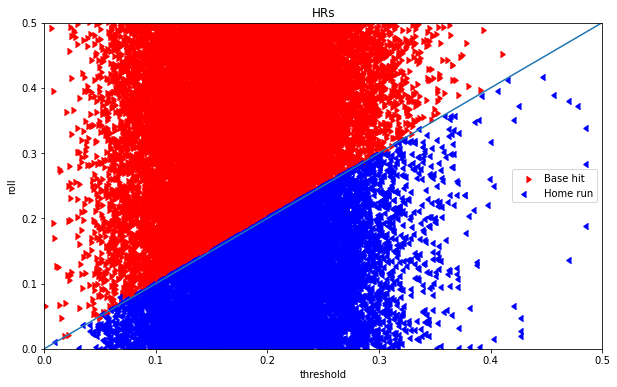

In [7]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Base hit",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Home run",
    marker=CARETLEFTBASE,
)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("HRs")
ax.set_xlim([0.0, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

2


,offset,weather,event_type,roll,threshold,div_vibes,opw_vibes,supp_vibes,baserunner_count,batter_name,pitcher_name,batter_mods,pitcher_mods,batter_mul,pitcher_mul,batting_team_mods,pitching_team_mods,day,game_id,play_count
22242,-0.005707,Weather.ECLIPSE,BaseHit,0.176848,0.182555,0.711890,0.558117,0.387174,0,Sutton Dreamy,Bontgomery Mullock,FLINCH,FRIEND_OF_CROWS;WILD,1.51,1.0,SINKING_SHIP;PARTY_TIME,LOVE,92,0f41944a-07cd-45f8-a9b0-b1b86e3bd942,315
53607,0.009016,Weather.PEANUTS,HomeRun,0.078978,0.069963,0.257933,1.063585,0.657244,0,Igneus Delacruz,Flattery McKinley,ALTERNATE;CHUNKY,ALTERNATE,1.00,1.0,BASE_INSTINCTS,UNDERSEA;PARTY_TIME,95,0f878c0e-4c9c-4600-89c5-b01b7bb14b56,190


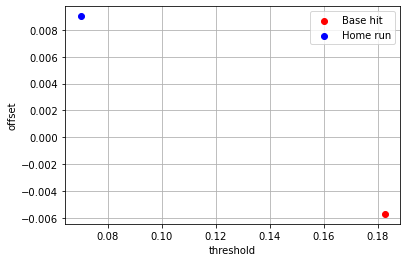

In [8]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
y_val = "offset"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Base hit")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Home run")
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]][y_val],
    color="red",
    label="Base hit",
)
ax.scatter(outliers[outliers["passed"]][x_val], outliers[outliers["passed"]][y_val], color="blue", label="Home run")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()
print(len(outliers))
table = outliers
# ax.set_yscale("log")
# ax.set_ylim(-0.5e-2, 0.5e-2)
ax.grid()
# fig.savefig("../figures/hr_fit_offsets_1.png", facecolor='white')
table[
    [
        "offset",
        "weather",
        "event_type",
        "roll",
        "threshold",
        "div_vibes",
        "opw_vibes",
        "supp_vibes",
        "baserunner_count",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batter_mul",
        "pitcher_mul",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset")

In [9]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.4166500940357283
0.019338279830648


In [10]:
table.groupby("pitching_team_mods").size()

pitching_team_mods
LOVE                   1
UNDERSEA;PARTY_TIME    1
dtype: int64

In [11]:
dfc.loc[
    7148,
    [
        "offset",
        "weather",
        "event_type",
        "roll",
        "threshold",
        "div_vibes",
        "opw_vibes",
        "supp_vibes",
        "baserunner_count",
        "batter_vibes",
        "pitcher_vibes",
        "batter_divinity",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batter_mul",
        "pitcher_mul",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
    ],
]

offset                                            0.719026
weather                                   Weather.FLOODING
event_type                                         BaseHit
roll                                               0.94401
threshold                                         0.224984
div_vibes                                         1.121897
opw_vibes                                         0.732422
supp_vibes                                        0.658526
baserunner_count                                         2
batter_vibes                                     -0.249415
pitcher_vibes                                     -0.47284
batter_divinity                                   1.180799
batter_name                                Thomas Dracaena
pitcher_name                         Fitzgerald Wanderlust
batter_mods                                     MAXIMALIST
pitcher_mods                                          WILD
batter_mul                                             1